- Gaining a conceptual understanding of multilayer NNs;
- Implementing the fundamental backpropagation algorithm for NN training from scratch;
- Training a basic multilayer NN for image classification.

# Modeling complex functions with artificial neural networks

Let's do a brief recap.

In the Adaline neuron we computed the gradient based on the whole training dataset and updated the weights of the model by taking a step in the opposite direction of the loss gradient $\nabla L(w)$ (for semplicity let's not focus on the bias unit). In order to find the optimal weights of the model, we optimized an objective function that we defined as the mean of squared errors loss function $L(w)$. Furthermore, we scaled the gradient by the learning rage $\eta$, to balance the speed of learning.

In gradient descent optimization, we updated all weights simultaneously after each epoch, and we defined the partial derivative for each weight $w_j$ in the weight vector $w$:
$$\frac{\partial L}{\partial w_j} = \frac{\partial}{\partial w_j}\frac{1}{n}\sum_i (y^{(i)} - a^{(i)})^2=-\frac{2}{n}\sum_i (y^{(i)} - a^{(i)})x_j^{(i)}$$
Where:
- $y^{(i)}$ is the target class label of a particular sample $x^{(i)}$, and $a^{(i)}$ is the activation function of the neuron, which is a linear function in the special case of Adaline;
- The activation is as follows: $\sigma(\cdot)=z=a$, where $z = \sum_jw_jx_j + b = w^Tx+b$;
- Plus we use a threshold functin to squash the continuous-valued output into binary class labels for prediction:
$$\hat{y}=\begin{cases}1\text{ if }\geq0;\\ 0 \text{ otherwise}\end{cases}$$

Also we learned about a certain trick to accelerate the model learning, the so-called stochastic gradient descent (SGD) optimization.

## Introducing the multilayer neural network architecture

Next to the data input, the multi layer perceptron (MLP) has one hidden layer and one output layer. The units in the hidden layer are fully connected to the input features, and the output layer is fully connected to the hidden layer. If such a network has more than one hidden layer, we also call it a deep NN.

> NOTE: we can add as many layer composed by as many neurons as we want but the loss gradients for updating the network's parameters, which we will calculate later via backpropagation, will become increasingly small as more layers are added to a network. This problem is called **vanishing gradient** and makes model learning more challenging. Therefore, special algorithms have been developed to help train such DNN structures.

## Activating a neural network via forward propagation

The MLP learning procedure can be summerized in three steps:
1. Starting at the input layer, we forward propagate the patterns of the training data through the network to generate an output;
2. Based on the network's output, we calculate the loss that we want to minimize using a loss function that we will describe later;
3. We backpropagate the loss, find its derivative with respect to each weight and bias unit in the network, and update the model.

Since each unit in the hidden layer is connected to all units in the input layers, we first calculate the activation unit of the hidden layer $a_1^{(h)}$ as follows:
$$z_1^{(h)} = \sum_{i=1}^m x_i^{(in)}w_{1,i}^{(h)} \\ a_1^{(h)} = \sigma(z_1^{(h)})$$

Here $\sigma(\cdot)$ is the activation function, which has to be differentiable to learn the weights that connect the neurons using a gradient-based approach.

To be able to solve complex problems such as image classification, we need nonlinear activation functions in our MLP model, for example, the sigmoid (logistic) activation function:
$$\sigma(z) = \frac{1}{1+e^{-z}}$$

The term feedforward refers to the fact that each layer serves as the input to the next layer without loops, in contrast to recurrent NNs.

We will now rewrite the feed-forward step in a more linear algebra-like manner:

$$z^{(h)}=x^{(in)}W^{(h)T}+b^{(h)} \\ a^{(h)} = \sigma(z^{(h)})$$
Here $x^{(in)}$ is a $1\times m$ dimensional feature vector, and $W^{(h)}$ is a $d\times m$ dimensional weight matrix where $d$ is the number of units in the hidden layer. The bias vector is a $1\times d$ vector.

After the matrix-vector multiplication, we obtain the ${1\times d}$ dimensional net input vector $z^{(h)}$ to calculate the activation $a^{(h)}$ (the result remains a $1\times d$ vector).

Furthermore we can generalize this computation to all $n$ examples in the training dataset:
$$Z^{(h)} = X^{(in)}W^{(h)T}+b^{(h)}$$

Similarly, we can write the activation of the output layer in vectorized form for multiple examples:
$$Z^{(out)} = A^{(h)}W^{(out)T}+b^{(out)}$$

> NOTE: after each layer pass the activation function $\sigma$ is applied all across the resulting vector $Z^{(\cdot)}$.

# Classifying handwritten digits

In [1]:
# Let's use the MNIST dataset
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784',version=1,return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [2]:
# Let's normalize the pixels (they are from 0 to 255 now)
X = ((X/255)-.5)*2

The reason behind the normalization is that gradient-based optimization is much more stable under these conditions.

Now let's visualize the images.

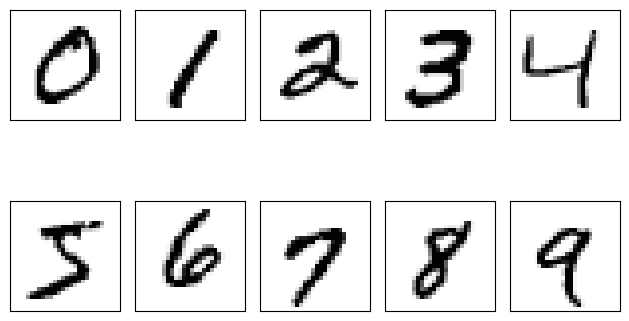

In [3]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y==i][0].reshape(28,28)
    ax[i].imshow(img,cmap="Greys")
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

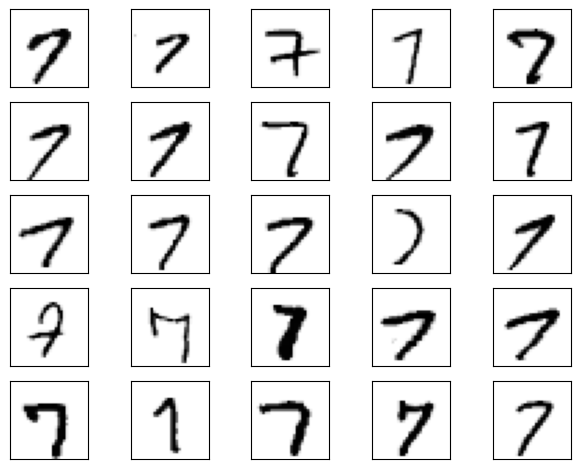

In [4]:
# Let's see how the same digit differs
fig, ax = plt.subplots(nrows=5,ncols=5,sharex=True,sharey=True)
ax = ax.flatten()

for i in range(25):
    img = X[y==7][i].reshape(28,28)
    ax[i].imshow(img,cmap="Greys")
ax[0].set_xticks([])
ax[0].set_yticks([])

plt.tight_layout()
plt.show()

In [17]:
# Let's do the datasplit
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X,y,test_size=10000,random_state=123,stratify=y)
X_train, X_valid, y_train , y_valid = train_test_split(X_temp,y_temp,test_size=5000,random_state=123,stratify=y_temp)

In [18]:
from multilayer_perceptron import NeuralNetMLP
model = NeuralNetMLP(num_features=28*28,num_hidden=50,num_classes=10)

In [7]:
# Let's code the NN training loop

import numpy as np
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X,y,minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0,indices.shape[0]-minibatch_size+1,minibatch_size):
        batch_idx = indices[start_idx:start_idx+minibatch_size]
        yield X[batch_idx], y[batch_idx]

for i in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train,y_train,minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [8]:
from multilayer_perceptron import int_to_onehot
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets,num_labels)
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

_, probas = model.forward(X_valid)
mse = mse_loss(y_valid,probas)
print(f'Initial validation MSE: {mse:.2f}')
predicted_labels = np.argmax(probas,axis=1)
acc = accuracy(y_valid,predicted_labels)
print(f'Initial validation accuracy: {acc*100:.2f}%')

Initial validation MSE: 0.27
Initial validation accuracy: 9.36%


As we can see the accuracy is not very high. However, given that we have a balanced dataset with 10 classes, a prediction accuracy of approximately 10 percent is what we would expect for an untrained model producing random predictions.

In [9]:
# Let's create a more efficient implementation of the MSE and acc calculation (seen that the dataset is pretty big)

def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X,y,minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas,axis=1)
        onehot_targets = int_to_onehot(targets,num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    mse = mse / i
    acc = correct_pred/num_examples
    return mse, acc

mse, acc = compute_mse_and_acc(model,X_valid,y_valid)
print(f'Initial validation MSE: {mse:.2f}')
print(f'Initial validation accuracy: {acc*100:.2f}%')

Initial validation MSE: 0.28
Initial validation accuracy: 9.36%


In [19]:
# Let's now define the training loop function

def train(model, X_train, y_train, X_valid, y_valid, num_epochs,learning_rate=0.1):
    epoch_loss=[]
    epoch_train_acc=[]
    epoch_valid_acc=[]

    for e in range(num_epochs):
        minibatch_gen = minibatch_generator(X_train,y_train,minibatch_size)
        for X_train_mini, y_train_mini in minibatch_gen:
            a_h, a_out = model.forward(X_train_mini)

            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_mini,a_h,a_out,y_train_mini)

            model.weight_h -= learning_rate*d_loss__d_w_h
            model.bias_h -= learning_rate*d_loss__d_b_h
            model.weight_out -= learning_rate*d_loss__d_w_out
            model.bias_out -= learning_rate*d_loss__d_b_out

        train_mse, train_acc = compute_mse_and_acc(model,X_train,y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model,X_valid,y_valid)
        train_acc,valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} | Train MSE: {train_mse:.2f} | Train ACC: {train_acc:.2f}% | Valid ACC: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [20]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model,X_train,y_train,X_valid,y_valid,num_epochs=50,learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train ACC: 76.15% | Valid ACC: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Train ACC: 85.45% | Valid ACC: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Train ACC: 87.82% | Valid ACC: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Train ACC: 89.36% | Valid ACC: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train ACC: 90.21% | Valid ACC: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train ACC: 90.67% | Valid ACC: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Train ACC: 91.12% | Valid ACC: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train ACC: 91.43% | Valid ACC: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Train ACC: 91.84% | Valid ACC: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Train ACC: 92.04% | Valid ACC: 91.84%
Epoch: 011/050 | Train MSE: 0.01 | Train ACC: 92.30% | Valid ACC: 92.08%
Epoch: 012/050 | Train MSE: 0.01 | Train ACC: 92.51% | Valid ACC: 92.24%
Epoch: 013/050 | Train MSE: 0.01 | Train ACC: 92.65% | Valid ACC: 92.30%
Epoch: 014/050 | Train MSE: 0.01 | Train ACC: 92.80

## Evaluating the neural network performance

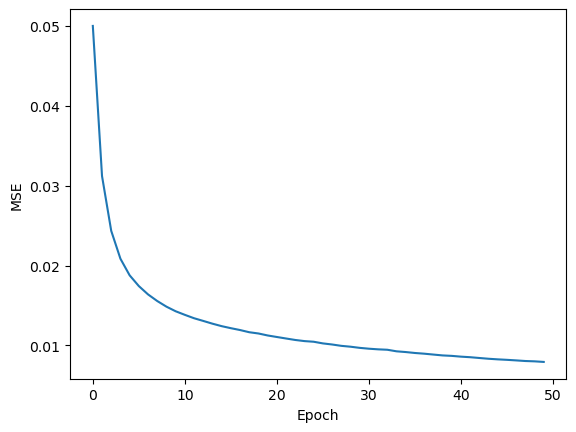

In [21]:
plt.plot(range(len(epoch_loss)),epoch_loss)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

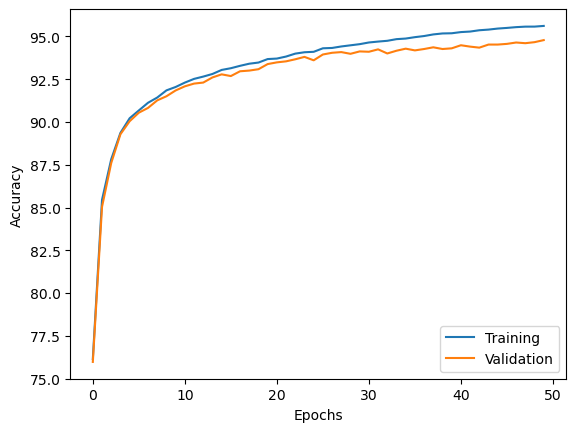

In [22]:
plt.plot(range(len(epoch_train_acc)),epoch_train_acc,label='Training')
plt.plot(range(len(epoch_valid_acc)),epoch_valid_acc,label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc="lower right")
plt.show()

Aswe can see the gap between training and validation accuracy increases as we train for more epochs.

In [23]:
test_mse, test_acc = compute_mse_and_acc(model,X_test,y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.54%


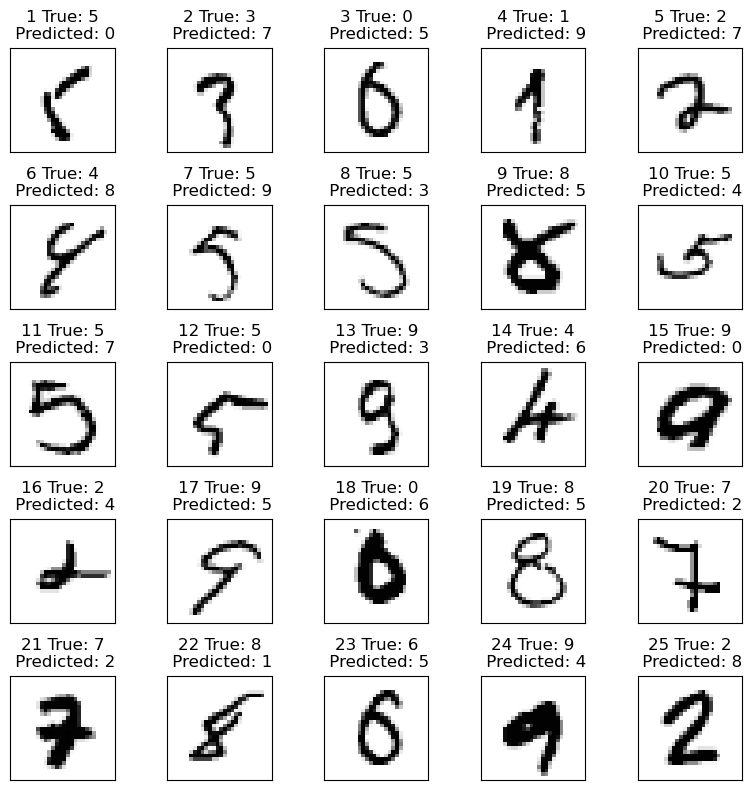

In [25]:
# Let's take a look at some of the images that our MLP struggles with, by extracting and plotting the first 25 missclassified samples from the test set

X_test_subset = X_test[:1000,:]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas,axis=1)

missclassified_images = X_test_subset[y_test_subset != test_pred][:25]
missclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig,ax = plt.subplots(nrows=5,ncols=5,sharex=True,sharey=True,figsize=(8,8))
ax = ax.flatten()
for i in range(25):
    img = missclassified_images[i].reshape(28,28)
    ax[i].imshow(img,cmap='Greys',interpolation='nearest')
    ax[i].set_title(f'{i+1} True: {correct_labels[i]}\n Predicted: {missclassified_labels[i]}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

# Training an artificial neural network (theory part)

## Computating the loss function

Remember that our goal is to minimize the loss function $L(W)$; thus we need to calculate the partial derivative of the parameters $W$ with respect to each weight for every layer in the network: $\frac{\partial}{\partial w_{j,l}^{(l)}} = L(W,b)$.

Note that $W$ consists of multiple matrices. In an MLP with one hidden layer, we have the weight matrix, $W^{(h)}$, which connects the input to the hidden layer, and $W^{(out)}, which connects the hidden layer to the output layer.

## Developing your understanding of backpropagation

We can think of backpropagation as a very computationally efficient approach to compute the partial derivatives of a complex, non-convex loss function in multilayer NNs. Here, our goal is to use those derivatives to learn the weight coefficients for parameterizing such a multilayer artificial NN. The challenge in the parameterization of NNs is that we are typically dealing with a very large number of model parameters in a high-dimensional feature space.

The chain rule is an approach to compute the derivative of a complex, nested function, such as $f(g(x))$, as follows:
$$\frac{d}{dx}[f(g(x))]=\frac{df}{dg}\cdot\frac{dg}{dx}$$

This can be done for arbitrarily long function composition:
$$F(x) = f(g(h(u(v(x)))))\\\frac{dF}{x} = \frac{d}{dx} F(x) = \frac{d}{dx} f(g(h(u(v(x))))) = \frac{df}{dg}\cdot\frac{dg}{dh}\cdot\frac{dh}{du}\cdot\frac{du}{dv}\cdot\frac{dv}{dx}$$

In the context of computer algebra, a set of techniques, known as automatic differentiation, has been developed to solve such problems very efficiently. Automatic differentiation comes with two modes, the forward and reverse modes; backpropagation is simply a special case of reverse-mode automatic differentiation. The key point is that applying the chain rule in forward mode could be quite expensive since we would have to multiply large matrices for each layer (Jacobians) that we would eventually multiply by a vector to obtain the output.

The trick of reverse mode is that we traverse the chain rule from right to left. We multiply a matrix by a vector, which yields another vector that is multiplied by the next matrix, and so on. Matrix-vector multiplication is computationally much cheaper than matrix-matrix multiplication, which is why backpropagation is one of the most popular algorithms used in NN training.

TODO: look at the paper that pioneered automatic differentiation [here](http://arxiv.org/pdf/1404.7456.pdf)

## Training neural networks via backpropagation

As we recall from the beginning of this chapter, we first need to apply forward propagation to obtain the activation of the outut layer, which we formulated as follows:
$$
Z^{(h)} = X^{(in)}W^{(h)T}+b^{(h)}\\
A^{(h)} = \sigma(Z^{(h)})\\
Z^{(out)} = A^{(h)}W^{(out)T}+b^{(out)}\\
A^{(out)} = \sigma(Z^{(out)})
$$
> OFF-TOPIC: really recommended to see the graphical explanation about all of this starting at page 364 of the book.

For semplicity, we will illustrate the process for the partial derivative used (including the net inputs z explicitly) to update the first weight in the weight matrix of the output layer (meaning the weight $w_{1,1}^{(out)}$ that weights the first input from the hidden layer $a_1^{(h)}$).

The partial derivative computation is as follows:
$$\frac{\partial L}{\partial w_{1,1}^{(out)}} = \frac{\partial L}{\partial a_{1}^{(out)}}\cdot\frac{\partial a_{1}^{(out)}}{\partial z_{1}^{(out)}}\cdot\frac{\partial z_{1}^{(out)}}{\partial w_{1,1}^{(out)}}$$

For semplicity, we will omit averaging over the individual examples in the mini-batch, so we drop the averaging term from the following equations.

Let's start with $\frac{\partial L}{\partial a_{1}^{(out)}}$, which is the partial derivative of the MSE loss w.r.t. the predicted output score of the first output node:
$$\frac{\partial L}{\partial a_{1}^{(out)}} = \frac{\partial}{\partial a_{1}^{(out)}}(y_1+a_1^{(out)})^2=2(a^{(out)}-y)$$

The next term is the derivative of the logistic sigmoid activation function that we used in the output layer:
$$\frac{\partial a_{1}^{(out)}}{\partial z_{1}^{(out)}} = \frac{\partial}{\partial z_{1}^{(out)}}\frac{1}{1+e^{-z_1^{(out)}}} = ... = \frac{1}{1+e^{-z_1^{(out)}}}(1-\frac{1}{1+e^{-z_1^{(out)}}}) = a_1^{(out)}(1-a_1^{(out)})$$

Lastly, we compute the derivative of the net input with respect to the weight:
$$\frac{\partial z_{1}^{(out)}}{\partial w_{1,1}^{(out)}} = \frac{\partial}{\partial w_{1,1}^{(out)}}a_1^{(h)}w^{(out)}_{1,1}+b^{(out)}_1 = a_1^{(h)}$$

Putting it all together, we get the following:
$$\frac{\partial L}{\partial w_{1,1}^{(out)}} = \frac{\partial L}{\partial a_{1}^{(out)}}\cdot\frac{\partial a_{1}^{(out)}}{\partial z_{1}^{(out)}}\cdot\frac{\partial z_{1}^{(out)}}{\partial w_{1,1}^{(out)}} = 2(a^{(out)}-y)a_1^{(out)}(1-a_1^{(out)})a_1^{(h)}$$

We then use this value to update the weight via the familiar stochastic gradient descent update with a learning rate of $\eta$:
$$w_{1,1}^{(out)} = w_{1,1}^{(out)} - \eta\frac{\partial L}{\partial w_{1,1}^{(out)}}$$

In the code we wrote we created the following "delta" placeholder variable:
$$\delta_1^{(out)} = \frac{\partial L}{\partial a_{1}^{(out)}}\cdot\frac{\partial a_{1}^{(out)}}{\partial z_{1}^{(out)}}$$
This is because $\delta^{(out)}$ terms are involved in computing the partial derivatives (or gradients of the hidden layer as well). To sum up, the delta (also interpretable as the error signal) is the amount to be used to multiply the derivative of the the net input, with regards to a weight matrix, in order to create the gradient that will be used (in the gradient descent pass) to slightly adjust the weights.

Speaking of hidden layer weights, is important to understand that since the weight $w_{1,1}^{(h)}$ is connected to all of the output nodes, we have to use multi-variable chain rule to cover all the paths that go from the output nodes to $w_{1,1}^{(h)}$:

$$\frac{\partial L}{\partial w_{1,1}^{(h)}} = \frac{\partial L}{\partial a_{1}^{(out)}}\cdot\frac{\partial a_{1}^{(out)}}{\partial z_{1}^{(out)}}\cdot\frac{\partial z_{1}^{(out)}}{\partial a_{1}^{(h)}}\cdot\frac{\partial a_{1}^{(h)}}{\partial z_{1}^{(h)}}\cdot\frac{\partial z_{1}^{(h)}}{\partial w_{1,1}^{(h)}}+...+\frac{\partial L}{\partial a_{2}^{(out)}}\cdot\frac{\partial a_{2}^{(out)}}{\partial z_{2}^{(out)}}\cdot\frac{\partial z_{2}^{(out)}}{\partial a_{1}^{(h)}}\cdot\frac{\partial a_{1}^{(h)}}{\partial z_{1}^{(h)}}\cdot\frac{\partial z_{1}^{(h)}}{\partial w_{1,1}^{(h)}}$$

Notice that if we reuse $\delta^{(out)}$ computed previously, this equation can be simplified as follows:
$$\frac{\partial L}{\partial w_{1,1}^{(h)}} = \delta^{(out)}_1\cdot\frac{\partial z_{1}^{(out)}}{\partial a_{1}^{(h)}}\cdot\frac{\partial a_{1}^{(h)}}{\partial z_{1}^{(h)}}\cdot\frac{\partial z_{1}^{(h)}}{\partial w_{1,1}^{(h)}}+...+\delta^{(out)}_2\cdot\frac{\partial z_{2}^{(out)}}{\partial a_{1}^{(h)}}\cdot\frac{\partial a_{1}^{(h)}}{\partial z_{1}^{(h)}}\cdot\frac{\partial z_{1}^{(h)}}{\partial w_{1,1}^{(h)}}$$

## About the convergence in neural networks
Mini-batch learning is a special form of SGD where we compute the gradient based on a subset $k$ of the $n$ training examples with $1<k<n$. Mini-batch learning has an advantage over online learning in that we can make use of our vectorized implementations to improve computational efficiency.

In multilayer NNs, we tipically have hundreds, thousands, or even billions of weights that we need to optimize. Unfortunately, the output function has a rough surface, and the optimization algorithm can easily become trapped in local minima. By increasing the learning rate, we can more readily escape such local minima. On the other hand, we also increase the chance of overshooting the global optimum if the learning rate is too large.